In [55]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
from torch.utils.data import DataLoader
from imblearn.over_sampling import RandomOverSampler
import os


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from transformers import Trainer , TrainingArguments , BertTokenizer , BertForSequenceClassification

import re
from nltk.corpus import stopwords

stopwords = set(stopwords.words("english"))

from transformers import AutoModelForSequenceClassification , AutoTokenizer


### Project Overview: Mental Health Text Classification with HuggingFace BERT

This project focuses on leveraging HuggingFace's BERT transformer model to classify mental health-related text into distinct categories. Mental health is a crucial area where technology can provide timely insights and support. The goal of this project is to build a robust machine learning model capable of accurately identifying the following mental health categories based on textual input:

- **Normal**  
- **Depression**  
- **Suicidal**  
- **Anxiety**  
- **Stress**  
- **Bipolar**  
- **Personality Disorder**  

### Key Features:
1. **State-of-the-Art NLP Model**: Utilizes HuggingFace's BERT, a powerful transformer-based architecture, known for its exceptional performance in text understanding tasks.  
2. **Multiclass Classification**: The model is trained to identify and classify text into one of the seven categories listed above.  
3. **Real-World Applications**: Potential applications include mental health screening, early intervention systems, and support tools for therapists and counselors.  

### Steps Involved:
1. **Data Collection and Preprocessing**:  
   - Gather labeled data corresponding to the seven classes.  
   - Clean and preprocess text data to ensure consistency and quality.  

2. **Model Training and Evaluation**:  
   - Fine-tune a pre-trained BERT model on the mental health dataset.  
   - Evaluate the model's performance using metrics such as precision, recall, F1-score, and accuracy.  

3. **Deployment**:  
   - Implement the trained model in an interactive application or API for real-world use.  

### Project Objective:
The primary aim is to demonstrate the power of BERT in understanding nuanced text data and to provide a tool that could assist in identifying and categorizing mental health conditions with high accuracy.  

This project not only showcases technical expertise in NLP but also emphasizes its potential to make a meaningful impact on society.

In [4]:
path = r"/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv"

if os.path.exists(path) :
    df = pd.read_csv(path)
    print("Successfully loaded file.")

else :
    print("Sorry, your file was not found.")
    

Successfully loaded file.


In [6]:
df.head(10)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
5,5,"every break, you must be nervous, like somethi...",Anxiety
6,6,"I feel scared, anxious, what can I do? And may...",Anxiety
7,7,Have you ever felt nervous but didn't know why?,Anxiety
8,8,"I haven't slept well for 2 days, it's like I'm...",Anxiety
9,9,"I'm really worried, I want to cry.",Anxiety


In [7]:
df.shape

(53043, 3)

In [8]:
df = df.dropna()

In [9]:
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [10]:
df = df.sample(n=6000 , random_state=42).reset_index(drop=True)
df

,Unnamed: 0,statement,status
0,3008,I'm lazy to complain about it ba ihh,Normal
1,44705,i think the wifi on my iphone is broken it wil...,Normal
2,50186,Good tracking apps? I've been trying to find a...,Bipolar
3,13755,I have recently looked into reddit and found t...,Depression
4,32298,that's your favorite thing to do?,Normal
...,...,...,...
5995,8480,What is around you right now? A photo? A comfo...,Depression
5996,16434,I am tired. I am ready for everything to be ov...,Suicidal
5997,28059,? What if I am at a friends party and a man wh...,Stress
5998,37770,if it add any kind of info m almost the thing ...,Depression


In [11]:
df.shape

(6000, 3)

In [12]:
df = df.drop(columns=["Unnamed: 0"] , axis=1)
df

,statement,status
0,I'm lazy to complain about it ba ihh,Normal
1,i think the wifi on my iphone is broken it wil...,Normal
2,Good tracking apps? I've been trying to find a...,Bipolar
3,I have recently looked into reddit and found t...,Depression
4,that's your favorite thing to do?,Normal
...,...,...
5995,What is around you right now? A photo? A comfo...,Depression
5996,I am tired. I am ready for everything to be ov...,Suicidal
5997,? What if I am at a friends party and a man wh...,Stress
5998,if it add any kind of info m almost the thing ...,Depression


In [18]:
df.describe(include="all").T

,count,unique,top,freq
statement,6000,5975,why is that?,3
status,6000,7,Normal,1894


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  6000 non-null   object
 1   status     6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [23]:
pd.DataFrame(df["status"].value_counts())

,count
status,
Normal,1894
Depression,1730
Suicidal,1219
Anxiety,429
Stress,304
Bipolar,293
Personality disorder,131


### Preprocessing Function Description

This function, `preprocessing(text)`, is designed to clean and preprocess text data for NLP tasks. It ensures that the text is in a format suitable for further analysis and model training. Below is a step-by-step description of the preprocessing steps:

1. **Convert to Lowercase**:
   - The input text is converted to lowercase to standardize it, making the text case-insensitive.
   
2. **Remove Punctuation**:
   - All punctuation marks (such as commas, periods, etc.) are removed from the text using regular expressions (`re.sub`). This helps to focus only on the words themselves.

3. **Remove Digits**:
   - Any digits in the text are removed. Since this project is focused on text classification, numerical values may not contribute meaningfully and are therefore excluded.

4. **Tokenization**:
   - The text is split into individual words (tokens). This step helps break the text into smaller units for processing.

5. **Remove Stopwords**:
   - Common words that do not contribute much to the meaning (such as "and," "the," "is," etc.) are removed using a predefined list of stopwords. This helps in reducing noise and retaining the most meaningful words.

6. **Rejoin Words**:
   - After filtering out stopwords, the remaining words are joined back together into a single string of text. This cleansed text is then returned for further use in the model.

### Additional Data Processing:
- The `cleaned_text` column is created by applying the `preprocessing` function to each row of the `statement` column.
- Two additional columns are added:
  - **`statement_length`**: Contains the length (in characters) of the original text.
  - **`cleaned_text_length`**: Contains the length (in characters) of the preprocessed text, which will likely be shorter than the original.

This preprocessing pipeline ensures that the text data is ready for model training, making the model more efficient and effective in processing the mental health text classification task.e length of the text before feeding it into the machine learning model.

# Preprocessing

In [24]:
def preprocessing(text) :
    
    text = text.lower()

    text = re.sub(r"[^\w\s]" , "" , text)

    text = re.sub(r"\d+" , "" , text)

    words = text.split()

    words = [w for w in words if w not in stopwords]

    preprocessing = " ".join(words)

    return preprocessing



df["cleaned_text"] = df["statement"].apply(preprocessing)

df["statement_length"] = df["statement"].apply(len)

df["cleaned_text_length"] = df["cleaned_text"].apply(len)

In [25]:
df.head(10)

,statement,status,cleaned_text,statement_length,cleaned_text_length
0,I'm lazy to complain about it ba ihh,Normal,im lazy complain ba ihh,36,23
1,i think the wifi on my iphone is broken it wil...,Normal,think wifi iphone broken quot connect quot act...,121,69
2,Good tracking apps? I've been trying to find a...,Bipolar,good tracking apps ive trying find apps track ...,414,258
3,I have recently looked into reddit and found t...,Depression,recently looked reddit found place actually qu...,3323,1951
4,that's your favorite thing to do?,Normal,thats favorite thing,33,20
5,I have enough goodies to play santa claus but ...,Suicidal,enough goodies play santa claus reindeer came ...,217,142
6,want to sleep but soon the call to prayer for ...,Normal,want sleep soon call prayer midday heavy sleepy,70,47
7,you use them to wipe the handle of the shoppin...,Normal,use wipe handle shopping cart,53,29
8,Is it good to only focus on 1 goal? What I mea...,Stress,good focus goal mean example goals find good j...,2577,1358
9,"Hi guys, I am looking for podcasts to listen t...",Depression,hi guys looking podcasts listen tall depressio...,571,403


In [26]:
df["cleaned_text"][10]

'lbs live parents drive addicted tomisuse weed compulsive overeater one thosedisgusting men cannot see anything relationship past sex attention template use describe term manchild manbabyif way waste human life see world crumbling prepared world comes crumbling hope suffering quick human garbage disposal chuck feel useless feel place world'

In [27]:
df['status'].value_counts()

status
Normal                  1894
Depression              1730
Suicidal                1219
Anxiety                  429
Stress                   304
Bipolar                  293
Personality disorder     131
Name: count, dtype: int64

In [28]:
# Split
X = df.drop(columns=["status"] , axis=1)
y = df["status"]


In [29]:
Ra_ov_sam = RandomOverSampler(random_state=42) 
X_train_res, y_train_res = Ra_ov_sam.fit_resample(X, y) 

df = pd.concat([X_train_res, y_train_res] , axis=1)

In [31]:
pd.DataFrame(df['status'].value_counts())

,count
status,
Normal,1894
Bipolar,1894
Depression,1894
Suicidal,1894
Stress,1894
Personality disorder,1894
Anxiety,1894


In [32]:
encode = LabelEncoder()

df["status"] = encode.fit_transform(df["status"])


X = df["statement"]

y = df["status"]

In [43]:
num_labels = len(df["status"].unique())
num_labels

7

In [33]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42)


print(f"X Train Shape is = {X_train.shape}")
print(f"X Test Shape is = {X_test.shape}")
print(f"y Train Shape is = {y_train.shape}")
print(f"y Test Shape is = {y_test.shape}")

X Train Shape is = (10606,)
X Test Shape is = (2652,)
y Train Shape is = (10606,)
y Test Shape is = (2652,)


In [34]:
y_train.unique()

array([0, 3, 2, 5, 4, 1, 6])

In [35]:
max([len(c) for c in df["statement"]])

11163

# Tokenizer 

### Tokenization with BERT Tokenizer Description

In this code snippet, we are using the **BertTokenizer** from HuggingFace to tokenize the text data for input into the BERT model. Tokenization is a critical step in preparing text data for BERT, as it converts the raw text into a format that the model can understand.

1. **BERT Tokenizer Initialization**:
   - `tok = BertTokenizer.from_pretrained("bert-base-uncased")`:
     - This line initializes the **BERT tokenizer** with the `bert-base-uncased` model. The "uncased" version of BERT means that the model does not differentiate between lowercase and uppercase characters. It is useful for text that doesn't rely on case-sensitive meanings.

2. **Tokenizing the Training Data**:
   - `train_encoding = tok(list(X_train), padding=True, truncation=True, max_length=200)`:
     - `X_train`: The training data (text) is passed as a list of sentences.
     - `padding=True`: This ensures that all sequences are padded to the same length (so that the BERT model can process them in batches).
     - `truncation=True`: This trims the text that exceeds the specified `max_length` (200 tokens in this case). This ensures that the model doesn't process unnecessarily long sequences.
     - `max_length=200`: The maximum length of the tokenized sequence. If any sentence exceeds 200 tokens, it will be truncated to this length.

3. **Tokenizing the Test Data**:
   - `test_encoding = tok(list(X_test), padding=True, truncation=True, max_length=200)`:
     - The same tokenization process is applied to the test data (`X_test`) to ensure it matches the format required by the BERT model.

### Purpose of Tokenization:
Tokenization splits the input text into subword units (tokens) and converts them into numerical IDs that can be processed by BERT. By padding, truncating, and ensuring all sequences have the same length, this step ensures that the input is consistent and ready for use in model training or evaluation.

These tokenized sequences are now ready for input into BERT for further processing and model training.

In [37]:
# Tokenization using BERT tokenizer

tok = BertTokenizer.from_pretrained("bert-base-uncased")

train_encoding = tok(list(X_train) , padding=True , truncation=True , max_length=200)
test_encodeing = tok(list(X_test) , padding=True , truncation=True , max_length=200)


### Converting Encoded Data to Dataset Format

This code snippet converts the tokenized training and test data into a dataset format using the **HuggingFace `datasets` library**. The `Dataset` class organizes the input data in a structured way, making it easier to use with transformers and other NLP models.

#### Step-by-Step Explanation:

1. **Importing the `Dataset` Class**:
   - `from datasets import Dataset`: Imports the `Dataset` class from the HuggingFace `datasets` library. This class is used to create and manage datasets efficiently.

2. **Creating the Training Dataset**:
   - `df_train = Dataset.from_dict({ ... })`:
     - The `Dataset.from_dict` method creates a `Dataset` object from a dictionary.
     - The dictionary includes:
       - **`input_ids`**: The token IDs generated during tokenization (`train_encoding["input_ids"]`).
       - **`attention_mask`**: A mask indicating which tokens are padding (`train_encoding["attention_mask"]`).
       - **`labels`**: The target labels for the training data, converted to a list using `y_train.tolist()`.

3. **Creating the Test Dataset**:
   - `df_test = Dataset.from_dict({ ... })`:
     - Similarly, the test data is converted into a `Dataset` object using the same structure:
       - **`input_ids`**: The token IDs for the test data (`test_encoding["input_ids"]`).
       - **`attention_mask`**: The attention masks for the test data (`test_encoding["attention_mask"]`).
       - **`labels`**: The target labels for the test data, converted to a list using `y_test.tolist()`.

#### Purpose:
- This conversion organizes the data in a structured format compatible with HuggingFace's transformers library.
- It facilitates seamless integration with data loaders, training pipelines, and evaluation processes.

#### Output:
- `df_train`: A `Dataset` object containing the tokenized input IDs, attention masks, and labels for the training data.
- `df_test`: A `Dataset` object containing the tokenized input IDs, attention masks, and labels for the test data.

These `Dataset` objects can now be used directly for training and evaluating the BERT model.

In [39]:
# Convert to Dataset format

from datasets import Dataset

df_train = Dataset.from_dict({"input_ids" : train_encoding["input_ids"] ,
                              "attention_mask" : train_encoding["attention_mask"] , 
                              "labels" : y_train.tolist()})



df_test = Dataset.from_dict({"input_ids" : test_encodeing["input_ids"] , 
                             "attention_mask" : test_encodeing["attention_mask"] , 
                             "labels" : y_test.tolist()})



# Fine Tuning Bert

### Fine-Tuning BERT for Sequence Classification

This code snippet demonstrates the process of fine-tuning a pre-trained **BERT model** for the sequence classification task. It leverages HuggingFace's `transformers` library to set up and execute the training pipeline efficiently.

---

#### 1. **Model Initialization**:
```python
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
```
- **`BertForSequenceClassification`**:
  - A pre-trained BERT model specifically designed for sequence classification tasks.
  - The `num_labels` parameter defines the number of output classes (e.g., 7 for this mental health text classification task).
- **`"bert-base-uncased"`**:
  - Specifies the base, uncased version of BERT, which ignores capitalization for robustness.

---

#### 2. **Training Arguments**:
```python
training_args = TrainingArguments(...)
```
- **`output_dir="./results"`**:
  - Directory to save the model checkpoints and outputs.
- **`evaluation_strategy="epoch"`**:
  - Evaluates the model at the end of every epoch.
- **`save_strategy="epoch"`**:
  - Saves the model checkpoint at the end of each epoch.
- **`learning_rate=2e-5`**:
  - The initial learning rate for the optimizer, a common starting value for fine-tuning transformers.
- **`per_device_train_batch_size=16`** and **`per_device_eval_batch_size=16`**:
  - Defines the batch size for training and evaluation on each device (e.g., GPU).
- **`num_train_epochs=5`**:
  - The model will train for 5 complete passes over the training dataset.
- **`weight_decay=0.01`**:
  - A regularization parameter to prevent overfitting.
- **`logging_dir="./logs"`** and **`logging_steps=10`**:
  - Configures logging for monitoring training progress.
- **`lr_scheduler_type="linear"`**:
  - Uses a linear learning rate scheduler.
- **`warmup_steps=500`**:
  - Gradually increases the learning rate over the first 500 steps to stabilize training.
- **`load_best_model_at_end=True`**:
  - Ensures the best model (based on evaluation metrics) is loaded after training.
- **`metric_for_best_model="eval_loss"`**:
  - Uses evaluation loss to determine the best model during training.
- **`save_total_limit=3`**:
  - Retains only the 3 most recent checkpoints to save storage.
- **`gradient_accumulation_steps=2`**:
  - Accumulates gradients over 2 steps before updating weights, effectively increasing the batch size.

---

#### 3. **Trainer Setup**:
```python
trainer = Trainer(...)
```
- **`Trainer`**:
  - A high-level API to train and evaluate models with minimal effort.
- **Parameters**:
  - **`model=model`**: Specifies the BERT model to be fine-tuned.
  - **`args=training_args`**: Training configuration.
  - **`train_dataset=df_train`**: The training dataset.
  - **`eval_dataset=df_test`**: The evaluation dataset.

---

#### 4. **Fine-Tuning the Model**:
```python
trainer.train()
```
- This command begins the fine-tuning process. The model learns to classify text into the predefined categories (e.g., Normal, Depression, etc.) by updating its weights based on the training data.

---

### Key Features of the Setup:
- Leverages the power of BERT for complex text understanding.
- Employs robust training strategies like gradient accumulation, warmup steps, and weight decay to optimize performance.
- Automatically saves and restores the best model for deployment.

This code efficiently prepares the BERT model for accurate mental health text classification.

In [46]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased" , num_labels=num_labels)


training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear",
    warmup_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    save_total_limit=3,
    gradient_accumulation_steps=2
)


# Trainer
trainer = Trainer(
    model=model , 
    args=training_args , 
    train_dataset=df_train , 
    eval_dataset=df_test
)


# Fine-tuning the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser 

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,1.585300,1.487161
2,0.688800,0.625621
3,0.292400,0.287353
4,0.175400,0.224931
5,0.120100,0.216010


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=830, training_loss=0.7419701263128993, metrics={'train_runtime': 1319.9773, 'train_samples_per_second': 40.175, 'train_steps_per_second': 0.629, 'total_flos': 5450549081100000.0, 'train_loss': 0.7419701263128993, 'epoch': 5.0})

#  Model Evaluation


In [47]:
pred , label , _ = trainer.predict(df_test)

pred_labels = np.argmax(pred , axis=1)


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [48]:
cm = confusion_matrix(pred_labels , y_test)
cm

array([[342,   0,   4,   4,   0,   0,   0],
       [  0, 397,   6,   2,   0,   0,   1],
       [  0,   0, 280,   4,   0,   0,  81],
       [  0,   0,   6, 374,   0,   0,   6],
       [  0,   0,   2,   0, 386,   0,   0],
       [  0,   0,   6,  13,   0, 361,   0],
       [  0,   0,  65,   4,   0,   0, 308]])

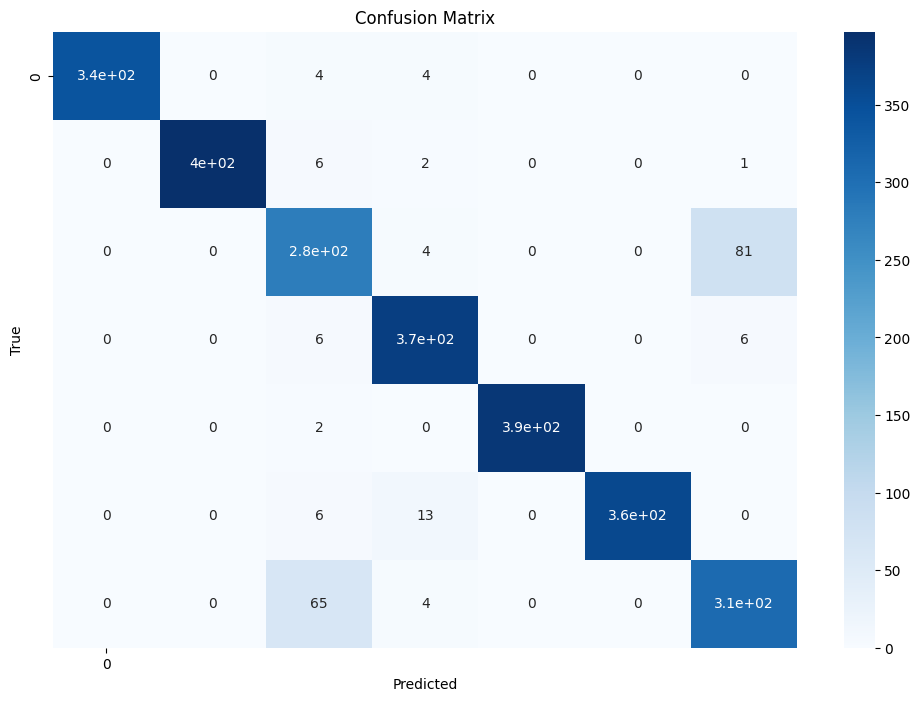

In [50]:
plt.figure(figsize=(12,8))
sns.heatmap(cm , annot=True , cbar=True , cmap="Blues" , xticklabels=num_labels , yticklabels=num_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [53]:
print(classification_report(pred_labels , y_test , target_names=encode.classes_))

                      precision    recall  f1-score   support

             Anxiety       1.00      0.98      0.99       350
             Bipolar       1.00      0.98      0.99       406
          Depression       0.76      0.77      0.76       365
              Normal       0.93      0.97      0.95       386
Personality disorder       1.00      0.99      1.00       388
              Stress       1.00      0.95      0.97       380
            Suicidal       0.78      0.82      0.80       377

            accuracy                           0.92      2652
           macro avg       0.92      0.92      0.92      2652
        weighted avg       0.93      0.92      0.92      2652



# Save and Load Model and Tokenizer

In [54]:
trainer.save_model("saved_mental_status_bert")

tok.save_pretrained("saved_mental_status_bert")

import pickle

pickle.dump(encode , open("encode.pkl" , "wb"))


In [56]:
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")

tok = AutoTokenizer.from_pretrained("saved_mental_status_bert")

encode = pickle.load(open("encode.pkl" , "rb"))


# Detection System

### Text Classification Function: Detecting Mental Health Categories

This section of the project implements a function to classify individual text inputs into one of the predefined mental health categories, leveraging the fine-tuned BERT model. Here's a detailed breakdown:

---

#### 1. **Detection Function**:
The function `detection_text(text)` is designed to:
- **Preprocess the Input Text**:
  - Applies the preprocessing pipeline to clean and standardize the input text. This ensures consistency with the training data.
- **Tokenize the Cleaned Text**:
  - Converts the cleaned text into tokenized input using the same BERT tokenizer (`tok`) applied during training.
  - The tokenization includes:
    - Padding: Ensures consistent input size.
    - Truncation: Trims input longer than 512 tokens.
    - Conversion to Tensor Format: Prepares data for PyTorch-based model inference.
- **Run the Model for Prediction**:
  - The processed input is fed into the fine-tuned BERT model, which returns logits representing raw classification scores.
- **Determine the Predicted Class**:
  - The logits are processed using `torch.argmax` to extract the class with the highest score, corresponding to the predicted category.
- **Map Class Index to Label**:
  - The predicted class index is translated back to its original category label using the inverse of the label encoding mechanism (`encode.inverse_transform`).

---

#### 2. **Sample Texts for Classification**:
A series of example sentences are passed through the `detection_text` function to demonstrate its performance. These examples represent various mental health states, such as:
- **Normal**: Indicating no signs of mental health concerns.
- **Depression**: Expressions of persistent sadness or hopelessness.
- **Suicidal**: Statements reflecting extreme despair or thoughts of self-harm.
- **Anxiety**: Concerns about potential negative outcomes or excessive worry.
- **Stress**: Feeling overwhelmed by life's demands.
- **Bipolar**: Alternating between high-energy, euphoric states and depressive episodes.
- **Personality Disorder**: Statements indicating potential signs of complex personality traits affecting thought patterns.

---

#### 3. **Execution Flow**:
- **Iterating Through Examples**:
  - Each sample text is passed through the `detection_text` function.
  - The predicted mental health category is displayed alongside the original sentence.
- **Output Format**:
  - For each input, the function outputs:
    - The original sentence.
    - The predicted mental health category in a clear and readable format.

---

#### 4. **Purpose and Significance**:
- This function serves as the core of the classification system, enabling real-time or batch processing of mental health-related text data.
- By automating the detection of mental health states, this tool can aid professionals in early detection and provide valuable insights for further intervention.

---

### Key Advantages:
- **Real-Time Classification**:
  - Processes and classifies individual text inputs quickly, making it suitable for live systems.
- **Fine-Tuned Model**:
  - Utilizes a BERT model tailored for the specific mental health categories, ensuring high accuracy.
- **Interpretability**:
  - Outputs human-readable labels, enhancing the practical usability of the system. 

This function is a crucial component of the project, demonstrating how advanced NLP techniques can be applied to address critical mental health challenges.

In [61]:
def detection_text(text) :
    cleaned_text = preprocessing(text)

    inputs = tok(cleaned_text , return_tensors="pt" , padding=True , truncation=True , max_length=512)
    outputs = model(**inputs)
    logists = outputs.logits  # Purpose: Extracts the logits from the model outputs. Logits are the raw, unnormalized scores for each class before applying softmax.
    pred_classes = torch.argmax(logists , dim=1).item()
    return encode.inverse_transform([pred_classes])[0]


sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]


for t in sample_texts :
    pred_classes = detection_text(t)
    print(f"Sentence: {t}\nPredicted class: ( {pred_classes} )\n")


Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Normal

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Normal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Depression

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Depression

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Depression

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Depression

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



# End 